# **Testing animations local**

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation, rc
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from cartopy import crs, feature

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D

rc('animation', html='html5')
from IPython.display import HTML, Video, Image

## Functions

#### Path prefix

In [2]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, f'{folder}/SalishSea_1{res}_{datestr}')
    
    return prefix

#### Scatter_Colors

In [3]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
def scatter_particles(ax, N,colors, nmin, nmax,yvar):
    scatter=[]
    #N is the number of stations
    #Color is a list of strings picking the desired colors
    #nmin is t0, nmax is tmax
    #yvar is the y coordinate
    
    starts = np.arange(0,N*n,n)
    ends = np.arange(n-1,N*n,n)
    if N < len(colors):
        colors = colors[0:N]
    elif N > len(colors):
        con = 0
        while N > len(colors):
            colors.append(colors[con])
            con+=1
    if nmin==nmax:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin], yvar[starts[i]:ends[i], nmin],c=colors[i],s=5))
    else:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin:nmax], yvar[starts[i]:ends[i], nmin:nmax],c=colors[i],s=5))
    return scatter

#### Useful Kernel

In [4]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

## Load drifters and definitions

In [5]:
# Define paths
paths = {
    'NEMO': '/results2/SalishSea/nowcast-green.201905/',
    'coords': '/Users/jvalenti/MOAD/SSC_masks/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/Users/jvalenti/MOAD/SSC_masks/mesh_mask201702.nc',
    'out': '/Users/jvalenti/MOAD/analysis-jose/notebooks/results/',
}

In [6]:
# Duration and timestep [s]
length = 10
duration = timedelta(days=length)
dt = 90 #toggle between - or + to pick backwards or forwards

In [7]:
N = 1 # number of deploying locations
n = 100 # 1000   # number of particles per location
# Define Gaussian point cloud in the horizontal
r = 1000   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
# Set a uniform distribution in depth, from dmin to dmax
dmin = 0.
dmax = 20.
zvals = dmin + np.random.random_sample([n,N]).T*(dmax-dmin)

## Simulation

In [8]:
start = datetime(2020, 12, 18)
daterange = [start+timedelta(days=i) for i in range(length)]
#Build filenames
Ulist, Vlist, Wlist = [], [], []
for day in range(duration.days):
    path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
    print (path_NEMO)
    Ulist.append(path_NEMO + '_grid_U.nc')
    Vlist.append(path_NEMO + '_grid_V.nc')
    Wlist.append(path_NEMO + '_grid_W.nc')

# Load NEMO forcing : note, depth aware but no vertical advection, particles stay at their original depth
filenames = {
    'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist},
    'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist},
    'W': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Wlist},
}
variables = {'U': 'vozocrtx', 'V': 'vomecrty','W': 'vovecrtz'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}

#bring salish sea results into field_set
#field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

/results2/SalishSea/nowcast-green.201905/18dec20/SalishSea_1h_20201218_20201218
/results2/SalishSea/nowcast-green.201905/19dec20/SalishSea_1h_20201219_20201219
/results2/SalishSea/nowcast-green.201905/20dec20/SalishSea_1h_20201220_20201220
/results2/SalishSea/nowcast-green.201905/21dec20/SalishSea_1h_20201221_20201221
/results2/SalishSea/nowcast-green.201905/22dec20/SalishSea_1h_20201222_20201222
/results2/SalishSea/nowcast-green.201905/23dec20/SalishSea_1h_20201223_20201223
/results2/SalishSea/nowcast-green.201905/24dec20/SalishSea_1h_20201224_20201224
/results2/SalishSea/nowcast-green.201905/25dec20/SalishSea_1h_20201225_20201225
/results2/SalishSea/nowcast-green.201905/26dec20/SalishSea_1h_20201226_20201226
/results2/SalishSea/nowcast-green.201905/27dec20/SalishSea_1h_20201227_20201227


### Change name for each run!!

In [9]:
# Set output file name.  Maybe change for each run
fn = f'storm-MP' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

/Users/jvalenti/MOAD/analysis-jose/notebooks/results/storm-MP20201218_1n_20201228_1n.nc


### Set particle location

In [10]:
lon = np.zeros([N,n])
lat = np.zeros([N,n])
# Execute run
clon, clat = [-123.901172,-125.155849,-123.207648,-122.427508,-123.399769,-123.277731], [49.186308,49.975326,49.305448,47.622403,48.399420,49.11602]  # choose horizontal centre of the particle cloud
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])
z = zvals

In [11]:
# pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=2))
# #pset.computeTimeChunk(allow_time_extrapolation=1)
# pset.execute(
#     pset.Kernel(AdvectionRK4_3D), runtime=duration, dt=dt,
#     output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
#     recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
# )

In [12]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

Text(0.5, 0, 'Longitude')

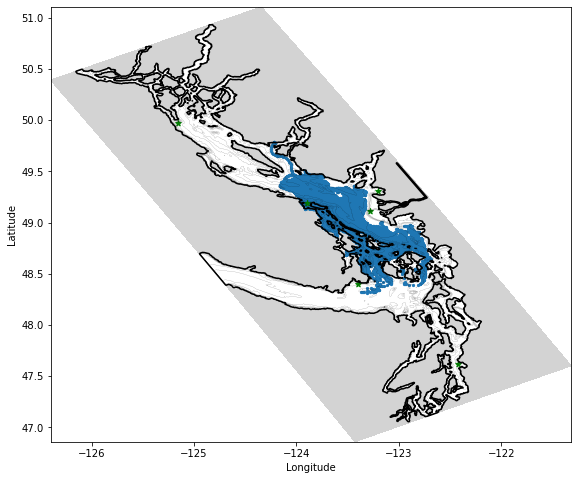

In [13]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_aspect(1/1)
nmin, nmax = 0, -1
#ax.scatter(ds.lon[:, nmax], ds.lat[:, nmax],c='b',s=2)
scatter_particles(ax, N,colors, nmin, nmax, ds.lat)
ax.scatter(clon,clat,c='g', marker='*', linewidths=1)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

Text(0.5, 0, 'Longitude')

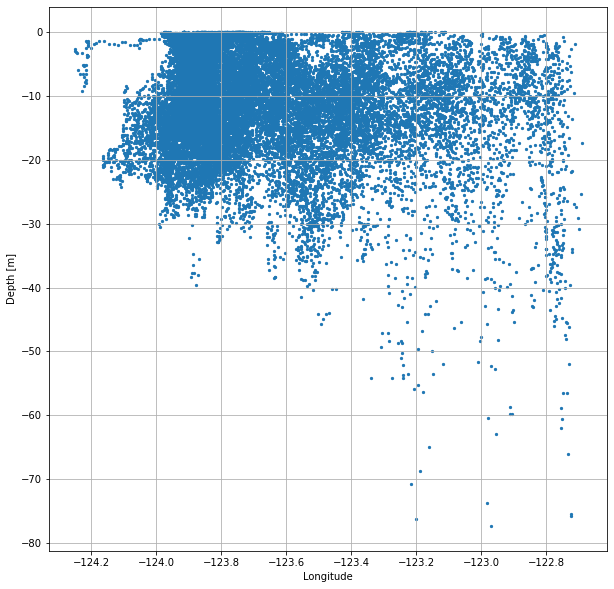

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter_particles(ax, N,colors, nmin, nmax, -ds.z)
ax.grid()
plt.ylabel('Depth [m]')
plt.xlabel('Longitude')

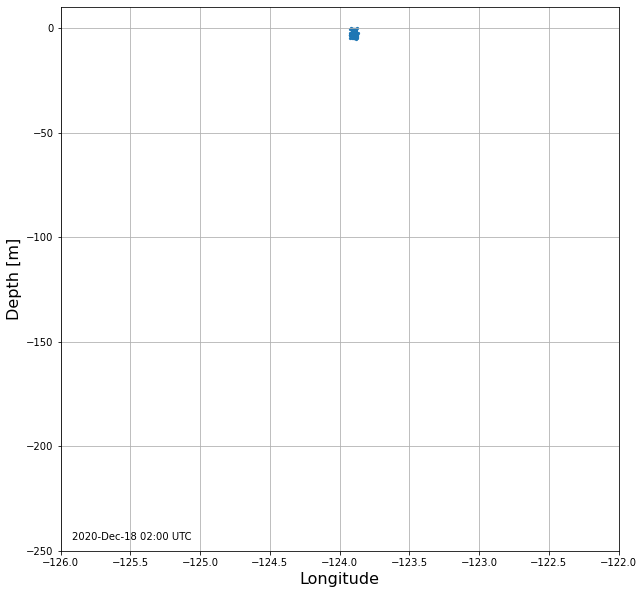

In [15]:
fps = 2
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(xlim=(-126,-122),ylim=(-250,10))
#Include time in animation
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
t.set_text('')
ss = scatter_particles(ax, N,colors, 0, 0, -ds.z)
plt.ylabel('Depth [m]',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
plt.grid()

def update(hour):
    tstamp = ds.time[0, hour].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    global ss
    for scat in ss:
        scat.remove()
    ss = scatter_particles(ax, N,colors, hour, hour, -ds.z)
    return ss

anim = animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps),repeat=True)

f = r"/Users/jvalenti/MOAD/animations/depths_storm.gif" 
FFwriter = animation.FFMpegWriter()
anim.save(f, writer = FFwriter)

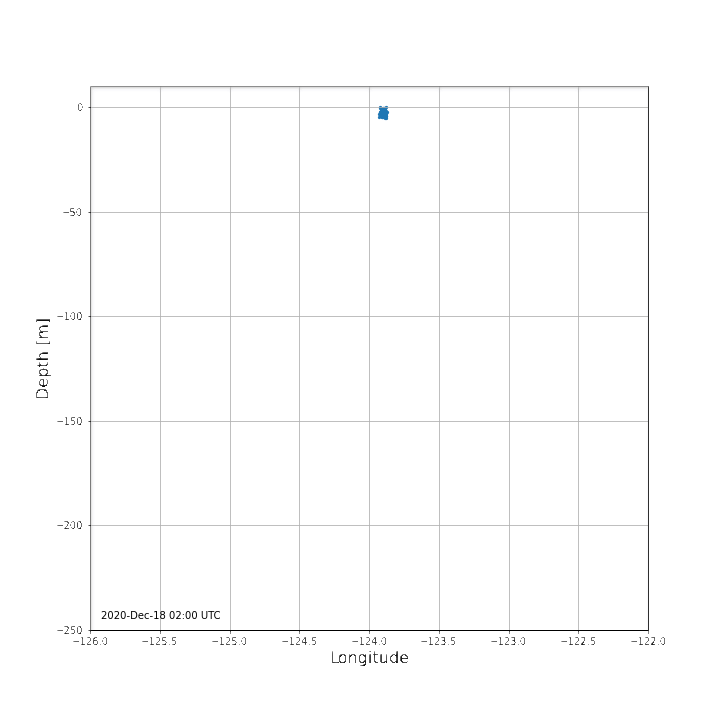

In [16]:
with open(f,'rb') as anim:
    display(Image(anim.read()))

In [17]:
###load YT
#ID_yt = "CGlbGgVnbos"
#YouTubeVideo(ID_yt)
###
#Video("/Users/jvalenti/MOAD/analysis-jose/notebooks/results/anim.mp4",embed=True) 

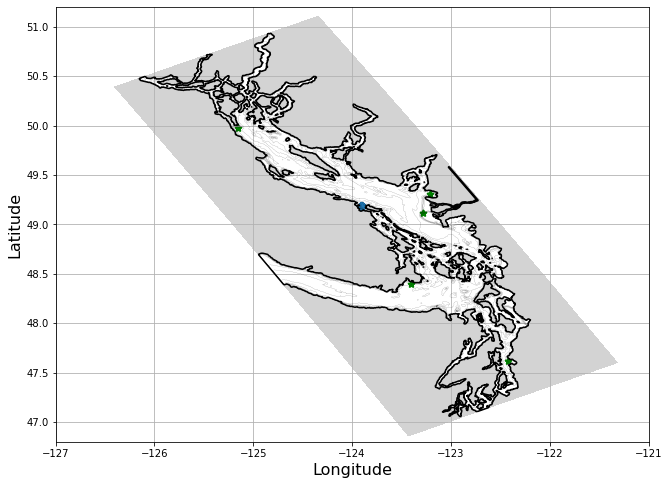

In [18]:
fps = 1
fig = plt.figure(figsize=(19, 8))
ax = plt.axes(xlim=(-127,-121),ylim=(46.8,51.2))
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.grid()
ax.set_aspect(1/1)
ax.scatter(clon,clat,c='g', marker='*', linewidths=2)
plt.ylabel('Latitude',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
ss = scatter_particles(ax, N,colors, 0,0, ds.lat)

def update(frames):
    global ss
    for scat in ss:
        scat.remove()
    ss = scatter_particles(ax, N,colors, frames,frames, ds.lat)
    return ss


anim = animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps))
anim
#f = r"/Users/jvalenti/MOAD/animations/storm.mp4" 
#FFwriter = animation.FFMpegWriter()
#anim.save(f, writer = FFwriter)

In [19]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
def scatterHD_particles(ax, N,colors, nmin, nmax,yvar):
    scatter=[]
    #N is the number of stations
    #Color is a list of strings picking the desired colors
    #nmin is t0, nmax is tmax
    #yvar is the y coordinate
    
    starts = np.arange(0,N*n,n)
    ends = np.arange(n-1,N*n,n)
    if N < len(colors):
        colors = colors[0:N]
    elif N > len(colors):
        con = 0
        while N > len(colors):
            colors.append(colors[con])
            con+=1
    if nmin==nmax:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin], yvar[starts[i]:ends[i], nmin],c=colors[i],s=5,transform=crs.PlateCarree(),zorder=1))
    else:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin:nmax], yvar[starts[i]:ends[i], nmin:nmax],c=colors[i],s=5,transform=crs.PlateCarree(),zorder=1))
    return scatter

/Users/jvalenti/conda_envs/parcels/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/jvalenti/conda_envs/parcels/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/jvalenti/conda_envs/parcels/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


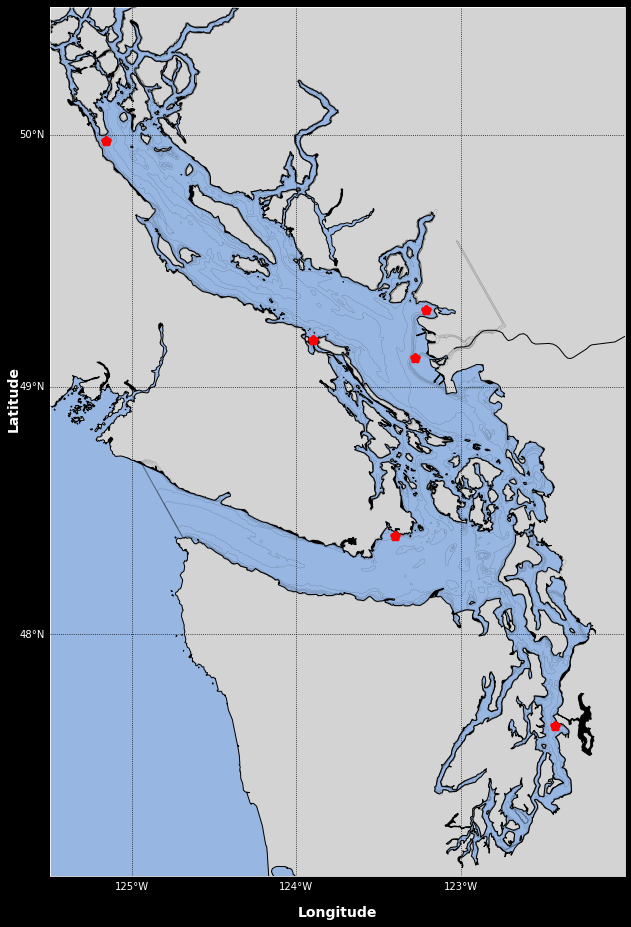

In [21]:
# Make map
fig, ax = plt.subplots(figsize=(38, 16), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([-125.5, -122, 47, 50.5], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('high', edgecolor='k', facecolor='lightgray'),zorder=2)
ax.add_feature(feature.RIVERS, edgecolor='k',zorder=5)
ax.add_feature(feature.OCEAN,zorder=1)
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1,zorder=3,transform=crs.PlateCarree())
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)

gl = ax.gridlines(
    linestyle=':', color='k', draw_labels=True,
    xlocs=range(-126, -121), ylocs=range(47, 52),zorder=5)
gl.top_labels, gl.right_labels = False, False

#ss = scatterHD_particles(ax, N,colors, -2, -1,ds.lat)

ax.scatter(clon,clat,c='r', marker='*', linewidth=5,transform=crs.PlateCarree(),zorder=4)
ax.text(-0.05, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")
ax.text(0.5, -0.05, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")
plt.style.use('dark_background')

--- 279.616975069046 seconds ---


<Figure size 1368x576 with 0 Axes>

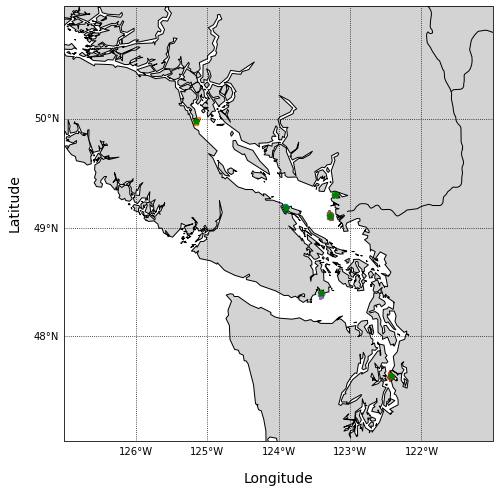

In [71]:
fps = 2
fig = plt.figure(figsize=(19, 8))
import time
start_time = time.time()

# Make map
fig, ax = plt.subplots(figsize=(19, 8), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([-127, -121, 47, 51], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', facecolor='lightgray'),zorder=2)
ax.add_feature(feature.RIVERS, edgecolor='k',zorder=5)

gl = ax.gridlines(
    linestyle=':', color='k', draw_labels=True,
    xlocs=range(-126, -121), ylocs=range(47, 52),zorder=5)
gl.top_labels, gl.right_labels = False, False
ss=scatterHD_particles(ax, N,colors, 0, 0,ds.lat)
ax.scatter(clon,clat,c='g', marker='*', linewidth=2,transform=crs.PlateCarree(),zorder=4)    
ax.text(-0.1, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14)
ax.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14)

def animate(frames):
    global ss
    for scat in ss:
        scat.remove()
    ss=scatterHD_particles(ax, N,colors, frames, frames,ds.lat)
    if frames == len(ds.lon[0,:])-1:
        print("--- %s seconds ---" % (time.time() - start_time))


anim = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(ds.lon[0,:]),fps))

#f = r"/Users/jvalenti/MOAD/animations/storm_HD.mp4" 
#FFwriter = animation.FFMpegWriter()
#anim.save(f, writer = FFwriter)